In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import pearsonr, spearmanr, kruskal
df = pd.read_csv(r"D:\coding\CEPP_Model\CEPP\Process\convert_json_data.csv")
# df = df.iloc[:900_000].copy()
# ===== helpers =====
def correlation_ratio(categories, measurements):
    """η (correlation ratio) : categorical X -> continuous y"""
    cats = pd.Series(categories)
    y = pd.to_numeric(pd.Series(measurements), errors='coerce')
    mask = cats.notna() & y.notna()
    if mask.sum() == 0: return np.nan
    cats = cats[mask]; y = y[mask]

    groups = []
    for k, g in y.groupby(cats):
        if len(g) >= 2:
            groups.append(g.values)
    if len(groups) <= 1: 
        return np.nan

    y_all = np.concatenate(groups)
    y_mean = y_all.mean()
    ss_between = sum(len(g)*(g.mean()-y_mean)**2 for g in groups)
    ss_total   = ((y_all - y_mean)**2).sum()
    eta2 = ss_between / ss_total if ss_total > 0 else np.nan
    return float(np.sqrt(eta2))  # return η (sqrt of η²)

def safe_pearson(x, y):
    try:
        r, p = pearsonr(x, y)
        return float(r) if np.isfinite(r) else np.nan
    except Exception:
        return np.nan

def safe_spearman(x, y):
    try:
        r = spearmanr(x, y, nan_policy='omit').correlation
        return float(r) if np.isfinite(r) else np.nan
    except Exception:
        return np.nan

# ===== regression report =====
def feature_target_report_regression(df, target, numeric_features, categorical_features, topk_MI=200):
    y = pd.to_numeric(pd.Series(target), errors='coerce')
    y = y.fillna(y.median())

    # เตรียมสำหรับ MI_reg
    X_mi = pd.DataFrame(index=df.index)
    for c in numeric_features:
        X_mi[c] = pd.to_numeric(df[c], errors='coerce').fillna(df[c].median())
    for c in categorical_features:
        X_mi[c] = df[c].astype('category').cat.codes  # NaN -> -1
    discrete_mask = X_mi.columns.isin(categorical_features)
    mi = mutual_info_regression(X_mi.values, y.values, discrete_features=discrete_mask, random_state=0)

    rows = []
    for i, c in enumerate(X_mi.columns):
        row = {"feature": c, "feat_type": "cat" if c in categorical_features else "num", "MI_reg": mi[i]}
        if c in numeric_features:
            x = pd.to_numeric(df[c], errors='coerce')
            mask = x.notna() & y.notna()
            if mask.any():
                xv, yv = x[mask].values, y[mask].values
                row["pearson"]  = safe_pearson(xv, yv)
                row["spearman"] = safe_spearman(xv, yv)
            else:
                row["pearson"] = row["spearman"] = np.nan
        else:
            # categorical feature vs continuous target
            row["corr_ratio"] = correlation_ratio(df[c], y)
            # เสริมสถิติ non-parametric ระหว่างกลุ่ม (Kruskal–Wallis)
            try:
                tmp = pd.DataFrame({"x": df[c], "y": y}).dropna()
                groups = [g["y"].values for _, g in tmp.groupby("x") if len(g) >= 2]
                if len(groups) >= 2:
                    row["kruskal_H"] = float(kruskal(*groups).statistic)
                else:
                    row["kruskal_H"] = np.nan
            except Exception:
                row["kruskal_H"] = np.nan
        rows.append(row)

    rep = pd.DataFrame(rows).sort_values("MI_reg", ascending=False)
    return rep.head(topk_MI)

# ===== plots (ใช้ต่อร่วมกับ report) =====
def minmax01(x: pd.Series) -> pd.Series:
    v = x.astype(float).copy()
    lo, hi = np.nanmin(v), np.nanmax(v)
    if not np.isfinite(lo) or not np.isfinite(hi) or hi <= lo:
        return pd.Series(np.zeros_like(v), index=x.index)  # all zeros if no spread
    return (v - lo) / (hi - lo)

def plot_heatmap_minmax(report, metrics=("MI_reg","pearson","spearman","corr_ratio","kruskal_H"),
                        topk=30, title="Feature–Target (min-max normalized)"):
    rep = report.copy()
    mcols = [m for m in metrics if m in rep.columns]
    if not mcols:
        print("No metrics to plot"); return
    # normalize each metric column to [0,1]
    for m in mcols:
        rep[m] = minmax01(rep[m])
    # จัดลำดับตามค่า max รวม
    rep["_max_abs"] = rep[mcols].max(axis=1)
    rep = rep.sort_values(["_max_abs","MI_reg"], ascending=False).head(topk)
    M = np.nan_to_num(rep[mcols].to_numpy(), nan=0.0)

    fig, ax = plt.subplots(figsize=(max(5,1.2*len(mcols)+2.5), max(2.5,0.35*len(rep)+1.5)))
    im = ax.imshow(M, aspect='auto')
    ax.set_xticks(np.arange(len(mcols))); ax.set_xticklabels(mcols, rotation=45, ha='right')
    ax.set_yticks(np.arange(len(rep)));   ax.set_yticklabels(rep["feature"].tolist())
    ax.set_title(title)
    cbar = fig.colorbar(im, ax=ax, shrink=0.8); cbar.ax.set_ylabel("normalized score", rotation=90)
    fig.tight_layout(); plt.show()

def plot_topk_metric_bar_reg(report, metric="MI_reg", k=20, title=None):
    if metric not in report.columns:
        print(f"Metric {metric} not in report."); return
    dfp = (report[["feature", metric]].dropna()
           .sort_values(metric, ascending=False).head(k).iloc[::-1])
    fig, ax = plt.subplots(figsize=(8, max(2.5, 0.4*k + 1.5)))
    ax.barh(dfp["feature"], dfp[metric])
    ax.set_xlabel(metric)
    ax.set_title(title if title else f"Top {k} features by {metric}")
    fig.tight_layout(); plt.show()


C:\Users\USER\AppData\Local\Temp\ipykernel_14936\2339125214.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_mi[c] = df[c].astype('category').cat.codes  # NaN -> -1
C:\Users\USER\AppData\Local\Temp\ipykernel_14936\2339125214.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_mi[c] = df[c].astype('category').cat.codes  # NaN -> -1
C:\Users\USER\AppData\Local\Temp\ipykernel_14936\2339125214.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which h

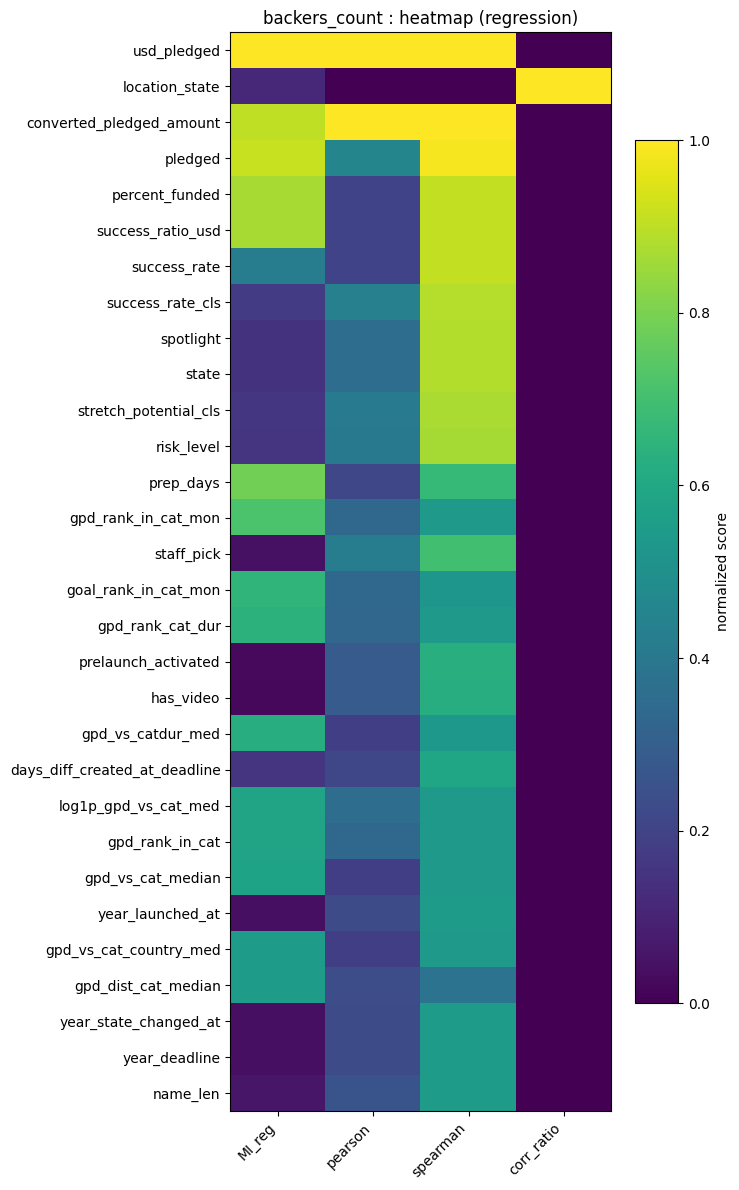

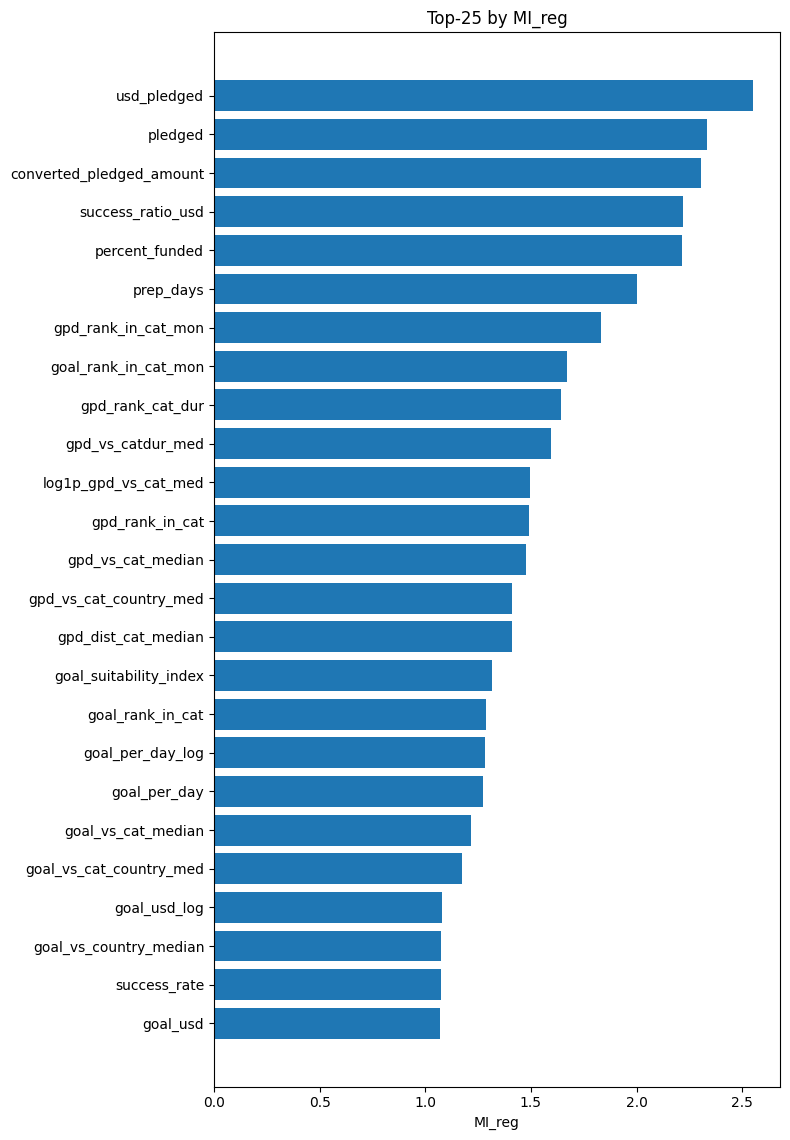

In [8]:
# กำหนดคอลัมน์ตามชุดข้อมูลของคุณ
CATEGORICAL_FEATURES = [        
    'currency',
    'country_displayable_name',
    'location_state',
    "dur_bin",
]
NUMERIC_FEATURES = [
    # 'backers_count',
    'converted_pledged_amount',
    'fx_rate',
    'goal',
    'percent_funded',
    'pledged',
    'prelaunch_activated',
    'spotlight',
    'staff_pick',
    'state',
    'static_usd_rate',
    'usd_exchange_rate',
    'usd_pledged',
    'success_rate',
    'has_video',
    'has_photo',
    'days_diff_created_at_deadline',
    'days_diff_state_changed_at_launched_at',
    'days_diff_launched_at_deadline',
    'days_diff_launched_at_deadline_log',
    'too_short_or_long',
    'name_len',
    'blurb_len',
    'year_created_at',
    'month_created_at',
    'day_created_at',
    'created_at_mon_sin',
    'created_at_mon_cos',
    'created_at_dom_sin',
    'created_at_dom_cos',
    'year_deadline',
    'month_deadline',
    'day_deadline',
    'deadline_mon_sin',
    'deadline_mon_cos',
    'deadline_dom_sin',
    'deadline_dom_cos',
    'year_state_changed_at',
    'month_state_changed_at',
    'day_state_changed_at',
    'state_changed_at_mon_sin',
    'state_changed_at_mon_cos',
    'state_changed_at_dom_sin',
    'state_changed_at_dom_cos',
    'year_launched_at',
    'month_launched_at',
    'day_launched_at',
    'launched_at_mon_sin',
    'launched_at_mon_cos',
    'launched_at_dom_sin',
    'launched_at_dom_cos',
    'prep_days',
    'launch_dow',
    'deadline_dow',
    'success_ratio_usd',
    'risk_level',
    'expected_pledge_baseline',
    'goal_suitability_index',
    'goal_eval',
    'duration_class',
    'success_rate_cls',
    'goal_usd',
    'goal_usd_log',
    'goal_per_day',
    'goal_per_day_log',
    'gpd_rank_in_cat',
    'gpd_vs_cat_median',
    'gpd_dist_cat_median',
    'log1p_gpd_vs_cat_med',
    'goal_rank_in_cat',
    'goal_vs_cat_median',
    'goal_vs_country_median',
    'goal_round_100',
    'goal_round_1000',
    'cat_freq',
    'country_freq',
    'cat_x_country_freq',
    'cat_country_share',
    'shortfall_severity_cls',
    'stretch_potential_cls',
    'prior_cat_mon_sr',
    'cat_mon_n',
    'cat_mon_goal_med',
    'cat_mon_gpd_med',
    'gpd_rank_in_cat_mon',
    'goal_rank_in_cat_mon',
    'goal_vs_cat_country_med',
    'gpd_vs_cat_country_med',
    'goal_last2',
    'goal_end_00',
    'goal_end_99',
    'goal_k_bucket',
    'gpd_rank_cat_dur',
    'gpd_vs_catdur_med',
    'cat_30d_launch_density',
    'cat_30d_density_rank',
    'cat_30d_density_z',
    'prior_cat_mon_goal',
    'goal_minus_prior_cat_mon',
    'prior_cat_country_mon_goal',
    'goal_minus_prior_cat_country_mon'
 ]


y_reg = df["backers_count"]

rep_reg = feature_target_report_regression(
    df, y_reg, NUMERIC_FEATURES, CATEGORICAL_FEATURES, topk_MI=200
)

_ = plot_heatmap_minmax(
    rep_reg,
    metrics = ("MI_reg","pearson","spearman","corr_ratio"),
    topk=30,
    title="backers_count : heatmap (regression)"
)

plot_topk_metric_bar_reg(rep_reg, metric="MI_reg", k=25, title="Top-25 by MI_reg")
